In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gdown
import os

file_id = "1t3F6jwU5wbC95MJbrs_c0bpwNtM1tQWi"
out_path = "mnist_unet_ema_weights.pth"

if not os.path.exists(out_path):
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        out_path,
        quiet=False,
    )
else:
    print("EMA weights already downloaded.")


Downloading...
From: https://drive.google.com/uc?id=1t3F6jwU5wbC95MJbrs_c0bpwNtM1tQWi
To: /home/onyxia/work/denoising-diffusion-model/measurement code/mnist_unet_ema_weights.pth
100%|██████████| 7.54M/7.54M [00:00<00:00, 88.3MB/s]


In [4]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


In [5]:
class Forward:
    def __init__(self, lambda_=1.0):
        self.lmbd = lambda_

    def mean(self, x0, t):
        t = t[:, None, None, None]
        return x0 * torch.exp(-self.lmbd * t)

    def std(self, t):
        t = t[:, None, None, None]
        std = torch.sqrt(1.0 - torch.exp(-2 * self.lmbd * t))
        return std.clamp(min=1e-3)

    def diffusion_coeff(self, t):
        # returns shape [B]
        return (2 * self.lmbd) ** 0.5 * torch.ones_like(t)


In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim
        self.lin = nn.Linear(dim, dim)

    def forward(self, t):
        # t: [B]
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=t.device) *
            -(torch.log(torch.tensor(10000.0, device=t.device)) / half_dim)
        )
        args = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)  # [B, dim]


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNetScore(nn.Module):
    def __init__(self, time_dim=32, base_channels=64):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)

        in_ch = 1 + time_dim  

        # Encoder
        self.down1 = ConvBlock(in_ch, base_channels)               # 28x28
        self.pool1 = nn.MaxPool2d(2)                               # 28->14

        self.down2 = ConvBlock(base_channels, base_channels * 2)   # 14x14
        self.pool2 = nn.MaxPool2d(2)                               # 14->7

        # Bottleneck
        self.bottleneck = ConvBlock(base_channels * 2, base_channels * 4)  # 7x7

        # Decoder
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)  # 7->14
        self.dec2 = ConvBlock(base_channels * 4, base_channels * 2)

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)      # 14->28
        self.dec1 = ConvBlock(base_channels * 2, base_channels)

        self.out_conv = nn.Conv2d(base_channels, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        emb = self.time_mlp(t)[:, :, None, None]
        emb = emb.expand(-1, -1, x.size(2), x.size(3))

        x_in = torch.cat([x, emb], dim=1)

        d1 = self.down1(x_in)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        u2 = torch.cat([u2, d2], dim=1)
        d2_dec = self.dec2(u2)

        u1 = self.up1(d2_dec)
        u1 = torch.cat([u1, d1], dim=1)
        d1_dec = self.dec1(u1)

        return self.out_conv(d1_dec)


In [7]:
@torch.no_grad()
def sample_reverse_euler_maruyama(
    model,
    sde,
    num_steps=500,
    batch_size=16,
    device="cuda",
    t_min=0.02,
):
    model.eval()
    T = 1.0

    t_grid = torch.linspace(T, t_min, num_steps, device=device)  # [N]
    x = torch.randn(batch_size, 1, 28, 28, device=device)        # start from prior

    for i in range(num_steps - 1):
        t_cur = t_grid[i]
        t_next = t_grid[i + 1]
        dt = t_next - t_cur  # dt < 0

        t_batch = torch.full((batch_size,), t_cur.item(), device=device)

        g = sde.diffusion_coeff(t_batch)          # [B]
        g2 = g ** 2
        g = g.view(batch_size, 1, 1, 1)
        g2 = g2.view(batch_size, 1, 1, 1)

        score = model(x, t_batch)                 # [B,1,28,28]
        drift = -sde.lmbd * x - g2 * score        # reverse drift (as used in your notebook)

        noise = torch.randn_like(x)
        x = x + drift * dt + g * torch.sqrt(-dt) * noise

        if torch.isnan(x).any() or torch.isinf(x).any():
            print("NaNs/Infs at step", i)
            break

    return x


In [8]:
MNIST_NAMES = [str(i) for i in range(10)]

def to_01_mnist(x):
    return (x.clamp(-1, 1) + 1) * 0.5

def show_mnist_row(samples, title="Samples"):
    x = to_01_mnist(samples.detach().cpu())
    B = x.size(0)

    plt.figure(figsize=(1.6 * B, 2.3))
    for i in range(B):
        plt.subplot(1, B, i + 1)
        plt.imshow(x[i, 0].numpy(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


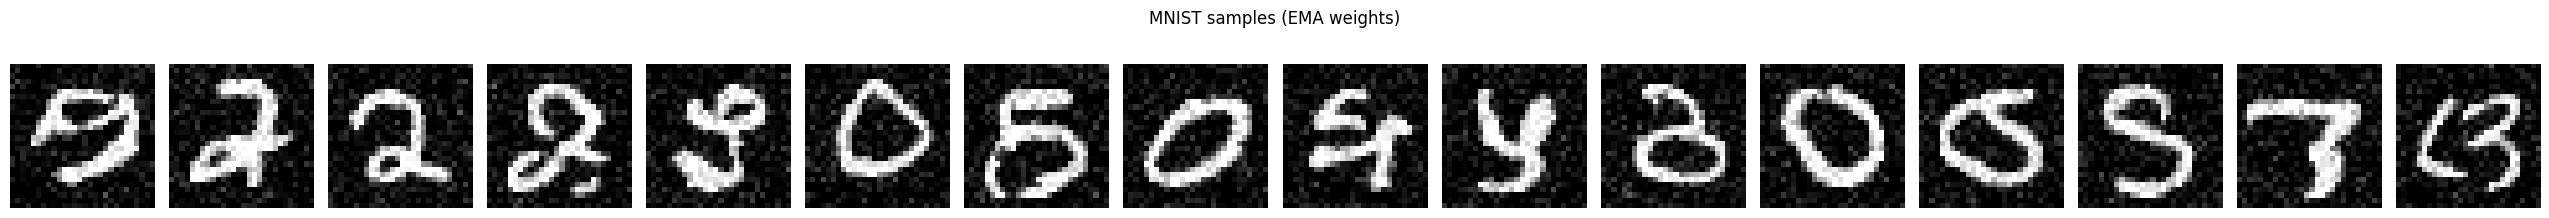

In [ ]:
time_dim = 32
base_channels = 64
lambda_ = 1.0
t_min = 0.02

ema_weights_path = "mnist_unet_ema_weights.pth"  

sde = Forward(lambda_=lambda_)
ema_model = UNetScore(time_dim=time_dim, base_channels=base_channels).to(device)

ema_sd = torch.load(ema_weights_path, map_location=device)
ema_model.load_state_dict(ema_sd, strict=True)
ema_model.eval()

samples = sample_reverse_euler_maruyama(
    ema_model, sde,
    num_steps=500,
    batch_size=16,
    device=device,
    t_min=t_min,
)

show_mnist_row(samples, title="MNIST samples (EMA weights)")


In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn

def _sync_if_cuda(device):
    if isinstance(device, str):
        is_cuda = "cuda" in device
    else:
        is_cuda = (device.type == "cuda")
    if is_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()

def _percentiles(xs, ps=(50, 95)):
    xs = np.asarray(xs, dtype=np.float64)
    return {f"p{p}": float(np.percentile(xs, p)) for p in ps}

class TimedModel(nn.Module):
    def __init__(self, model: nn.Module, device="cuda"):
        super().__init__()
        self.model = model
        self.device = device
        self.reset_stats()

    def reset_stats(self):
        self.nfe = 0
        self.model_ms = 0.0

    @torch.no_grad()
    def forward(self, *args, **kwargs):
        self.nfe += 1
        if torch.cuda.is_available() and ("cuda" in str(self.device)):
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            out = self.model(*args, **kwargs)
            end.record()
            torch.cuda.synchronize()
            self.model_ms += start.elapsed_time(end)
            return out
        else:
            t0 = time.perf_counter()
            out = self.model(*args, **kwargs)
            t1 = time.perf_counter()
            self.model_ms += (t1 - t0) * 1000.0
            return out

SAMPLE_FN_NAME = "sample_reverse_euler_maruyama"
assert SAMPLE_FN_NAME in globals(), f"Sampler {SAMPLE_FN_NAME} not found. Available: {list(globals().keys())[:30]}..."
_sampler = globals()[SAMPLE_FN_NAME]


@torch.no_grad()
def sampler_timed(timed_model, sde, *, num_steps, batch_size, device, t_min):
    return _sampler(
        model=timed_model,
        sde=sde,
        num_steps=num_steps,
        batch_size=batch_size,
        device=device,
        t_min=t_min,
    )


def run_sampling_benchmark(
    model: nn.Module,
    sde,
    sampler_fn,
    *,
    num_steps: int,
    batch_size: int,
    device="cuda",
    t_min=0.02,
    warmup_runs=2,
    timed_runs=10,
    reset_cuda_peak_mem=True,
):
    timed_model = TimedModel(model, device=device).to(device)

    for _ in range(warmup_runs):
        timed_model.reset_stats()
        _sync_if_cuda(device)
        _ = sampler_fn(timed_model, sde, num_steps=num_steps, batch_size=batch_size, device=device, t_min=t_min)
        _sync_if_cuda(device)

    per_img_total_ms = []
    per_img_model_ms = []
    per_img_overhead_ms = []
    nfes_per_run = []
    ms_per_forward_total = []
    ms_per_forward_model = []
    throughput_img_per_s = []
    peak_alloc_mb = []
    peak_reserved_mb = []

    for _ in range(timed_runs):
        timed_model.reset_stats()

        if reset_cuda_peak_mem and torch.cuda.is_available() and ("cuda" in str(device)):
            torch.cuda.reset_peak_memory_stats()

        _sync_if_cuda(device)
        t0 = time.perf_counter()
        _ = sampler_fn(timed_model, sde, num_steps=num_steps, batch_size=batch_size, device=device, t_min=t_min)
        _sync_if_cuda(device)
        t1 = time.perf_counter()

        total_ms_batch = (t1 - t0) * 1000.0
        model_ms_batch = float(timed_model.model_ms)
        overhead_ms_batch = total_ms_batch - model_ms_batch

        nfe_batch = int(timed_model.nfe)
        nfes_per_run.append(nfe_batch)

        total_ms_img = total_ms_batch / batch_size
        model_ms_img = model_ms_batch / batch_size
        overhead_ms_img = overhead_ms_batch / batch_size

        per_img_total_ms.append(total_ms_img)
        per_img_model_ms.append(model_ms_img)
        per_img_overhead_ms.append(overhead_ms_img)

        denom = max(nfe_batch, 1)
        ms_per_forward_total.append(total_ms_batch / denom)
        ms_per_forward_model.append(model_ms_batch / denom)

        throughput_img_per_s.append(1000.0 / max(total_ms_img, 1e-12))

        if torch.cuda.is_available() and ("cuda" in str(device)):
            peak_alloc_mb.append(torch.cuda.max_memory_allocated() / (1024**2))
            peak_reserved_mb.append(torch.cuda.max_memory_reserved() / (1024**2))

    summary = {
        "num_steps": num_steps,
        "batch_size": batch_size,
        "t_min": t_min,
        "timed_runs": timed_runs,
        "nfe_per_sample_percentiles": _percentiles(nfes_per_run, ps=(50, 95)),
        "nfe_per_img_legacy_percentiles": _percentiles([n / batch_size for n in nfes_per_run], ps=(50,)),
        "total_ms_percentiles": _percentiles(per_img_total_ms, ps=(50, 95)),
        "model_ms_percentiles": _percentiles(per_img_model_ms, ps=(50, 95)),
        "overhead_ms_percentiles": _percentiles(per_img_overhead_ms, ps=(50, 95)),
        "ms_per_forward_total_percentiles": _percentiles(ms_per_forward_total, ps=(50, 95)),
        "ms_per_forward_model_percentiles": _percentiles(ms_per_forward_model, ps=(50, 95)),
        "throughput_img_per_s_percentiles": _percentiles(throughput_img_per_s, ps=(50, 95)),
    }

    if peak_alloc_mb:
        summary["peak_alloc_mb_p50"] = _percentiles(peak_alloc_mb, ps=(50,))["p50"]
        summary["peak_reserved_mb_p50"] = _percentiles(peak_reserved_mb, ps=(50,))["p50"]

    return summary


def pretty_print_summary(summary: dict, name=""):
    print(f"\n=== Benchmark: {name} ===")
    print(f"steps={summary['num_steps']} | batch={summary['batch_size']} | timed_runs={summary['timed_runs']}")
    print(f"NFE/sample p50: {summary['nfe_per_sample_percentiles']['p50']:.1f} | p95: {summary['nfe_per_sample_percentiles']['p95']:.1f}")
    print(f"NFE/img (legacy: NFE/sample ÷ batch) p50: {summary['nfe_per_img_legacy_percentiles']['p50']:.3f}")

    print(f"total ms/img p50: {summary['total_ms_percentiles']['p50']:.3f} | p95: {summary['total_ms_percentiles']['p95']:.3f}")
    print(f"model ms/img p50: {summary['model_ms_percentiles']['p50']:.3f} | p95: {summary['model_ms_percentiles']['p95']:.3f}")
    print(f"overhd ms/img p50: {summary['overhead_ms_percentiles']['p50']:.3f} | p95: {summary['overhead_ms_percentiles']['p95']:.3f}")

    print(
        f"ms/forward TOTAL p50: {summary['ms_per_forward_total_percentiles']['p50']:.6f} | "
        f"p95: {summary['ms_per_forward_total_percentiles']['p95']:.6f}"
    )
    print(
        f"ms/forward MODEL p50: {summary['ms_per_forward_model_percentiles']['p50']:.6f} | "
        f"p95: {summary['ms_per_forward_model_percentiles']['p95']:.6f}"
    )

    print(
        f"throughput img/s p50: {summary['throughput_img_per_s_percentiles']['p50']:.2f} | "
        f"p95: {summary['throughput_img_per_s_percentiles']['p95']:.2f}"
    )

    if "peak_alloc_mb_p50" in summary:
        print(f"peak alloc MB p50: {summary['peak_alloc_mb_p50']:.1f} | peak reserved MB p50: {summary['peak_reserved_mb_p50']:.1f}")


device = device if "device" in globals() else ("cuda" if torch.cuda.is_available() else "cpu")
model_to_bench = ema_model if "ema_model" in globals() else model

NUM_STEPS = 500
T_MIN = 0.02

b16 = run_sampling_benchmark(model_to_bench, sde, sampler_timed,
                             num_steps=NUM_STEPS, batch_size=16, device=device, t_min=T_MIN,
                             warmup_runs=2, timed_runs=10)
pretty_print_summary(b16, name=f"MNIST diffusion | Euler--Maruyama | steps={NUM_STEPS} | batch=16")

b128 = run_sampling_benchmark(model_to_bench, sde, sampler_timed,
                              num_steps=NUM_STEPS, batch_size=128, device=device, t_min=T_MIN,
                              warmup_runs=2, timed_runs=10)
pretty_print_summary(b128, name=f"MNIST diffusion | Euler--Maruyama | steps={NUM_STEPS} | batch=128")



=== Benchmark: MNIST diffusion | Euler--Maruyama | steps=500 | batch=16 ===
steps=500 | batch=16 | timed_runs=10
NFE/sample p50: 499.0 | p95: 499.0
NFE/img (legacy: NFE/sample ÷ batch) p50: 31.188
total ms/img p50: 93.350 | p95: 94.929
model ms/img p50: 80.340 | p95: 80.910
overhd ms/img p50: 12.985 | p95: 14.021
ms/forward TOTAL p50: 2.993178 | p95: 3.043819
ms/forward MODEL p50: 2.576017 | p95: 2.594315
throughput img/s p50: 10.71 | p95: 10.75
peak alloc MB p50: 67.6 | peak reserved MB p50: 106.0

=== Benchmark: MNIST diffusion | Euler--Maruyama | steps=500 | batch=128 ===
steps=500 | batch=128 | timed_runs=10
NFE/sample p50: 499.0 | p95: 499.0
NFE/img (legacy: NFE/sample ÷ batch) p50: 3.898
total ms/img p50: 80.245 | p95: 81.401
model ms/img p50: 77.455 | p95: 79.061
overhd ms/img p50: 2.619 | p95: 3.071
ms/forward TOTAL p50: 20.583911 | p95: 20.880348
ms/forward MODEL p50: 19.868222 | p95: 20.280091
throughput img/s p50: 12.46 | p95: 12.69
peak alloc MB p50: 366.8 | peak reserved 